In [2]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import numpy as np
import os
import pandas as pd

from tqdm import tqdm
from functools import partial
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [3]:
colors = ["#2965CC", "#29A634", "#D99E0B", "#D13913", "#8F398F",
          "#00B3A4", "#DB2C6F", "#9BBF30", "#96622D", "#7157D9"]

Quelques outils pour visualiser les données et les résultats de prédiction.
On cherche notamment à :
* observer la distribution des catégories de l'ensemble d'entrainement
* observer la performance prédictive pour chaque catégorie

# Chargement des données

## Loading...

In [4]:
dataFolder = './challenge_data'
xPath = os.path.join(dataFolder, 'input_train.csv')
yPath = os.path.join(dataFolder,
                     'challenge_output_data_training_file_predict_the_expected_answer.csv')

# Loading, parsing and spliting training and testing data
x = pd.read_csv(xPath, delimiter=';', usecols=[0, 1]).values
y = pd.read_csv(yPath, delimiter=';', usecols=[0, 1]).values

## Global Variables

In [2]:
NUMBER_CATEGORIES = len(set(y[:,1]))
print(NUMBER_CATEGORIES)
STOP_WORDS = ['alors','au','aucuns','aussi','autre','avant','avec','avoir','bon','car',
              'ce','cela','ces','ceux','chaque','ci','comme','comment','dans','des',
              'du','dedans','dehors','depuis','devrait','doit','donc','dos','début','elle',
              'elles','en','encore','essai','est','et','eu','fait','faites','fois',
              'font','hors','ici','il','ils','je','juste','la','le','les',
              'leur','là','ma','maintenant','mais','mes','mine','moins','mon','mot',
              'même','ni','nommés','notre','nous','ou','où','par','parce','pas',
              'peut','peu','plupart','pour','pourquoi','quand','que','quel','quelle','quelles',
              'quels','qui','sa','sans','ses','seulement','si','sien','son','sont',
              'sous','soyez','sujet','sur','ta','tandis','tellement','tels','tes','ton',
              'tous','tout','trop','très','tu','voient','vont','votre','vous','vu',
              'ça','étaient','état','étions','été','être']

NameError: name 'y' is not defined

# Distribution du vocabulaire

In [6]:
def parseWord(wordCount, totalWordCount, density, item):
    if density:
        return [item[0], wordCount[0, item[1]] / totalWordCount]
    else:
        return [item[0], wordCount[0, item[1]]]

def vectorizeVocabulary(corpus, verbose=False, density=False):
    # Generate word tokens
    countVectorizer = CountVectorizer(input='content')
    countVector = countVectorizer.fit_transform(corpus)
    vocabulary = countVectorizer.vocabulary_
    wordCount = np.sum(countVector, axis=0)
    totalWordCount = np.sum(wordCount)

    vocabulary = list(map(partial(parseWord, wordCount,
                                  totalWordCount, density), vocabulary.items()))
    
    # Sort words by usage
    sortedVocabulary = sorted(vocabulary, key=lambda x: x[1], reverse=True)
    
    if verbose:
        print("countVector.shape: {}".format(str(countVector.shape)))
        print("wordCount.shape: {}".format(str(wordCount.shape)))
        print(sortedVocabulary[:5])
    
    return sortedVocabulary

In [7]:
def plotVocabulary(vocabulary, numberWords=50):
    labels = [word[0] for word in vocabulary[:numberWords]]
    values = [word[1] for word in vocabulary[:numberWords]]
    yPosition = np.arange(len(labels))

    plt.figure(figsize=(15,8))
    plt.bar(yPosition, values, color=colors[0])
    plt.xticks(yPosition, labels, rotation=90)
    plt.ylabel('Unique count')
    plt.title('Word')

    plt.show()

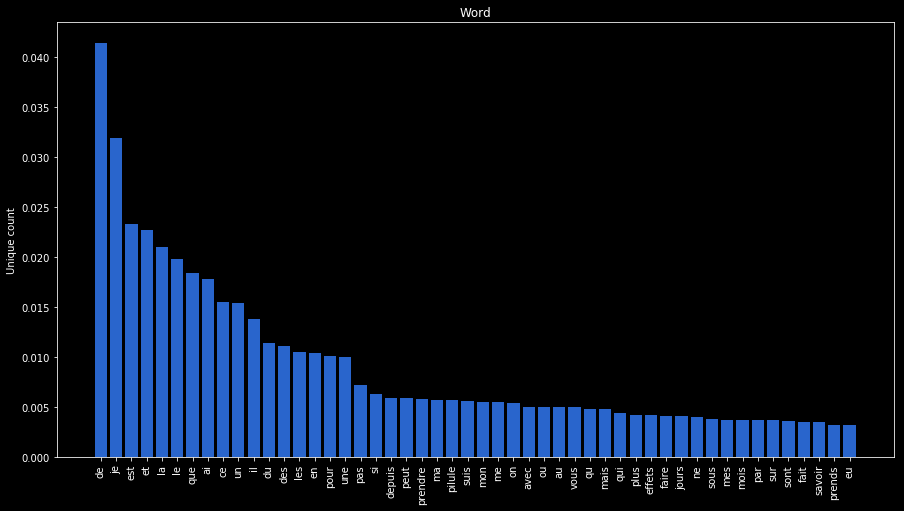

In [8]:
sentences = x[:,1]
sortedVocabulary = vectorizeVocabulary(sentences, verbose=False, density=True)
plotVocabulary(sortedVocabulary)

# Distribution des catégories

In [9]:
countCategories = [0] * NUMBER_CATEGORIES

for point in y:
    countCategories[point[1]] += 1

indexedCountCategories = list(zip(list(range(NUMBER_CATEGORIES)), countCategories))

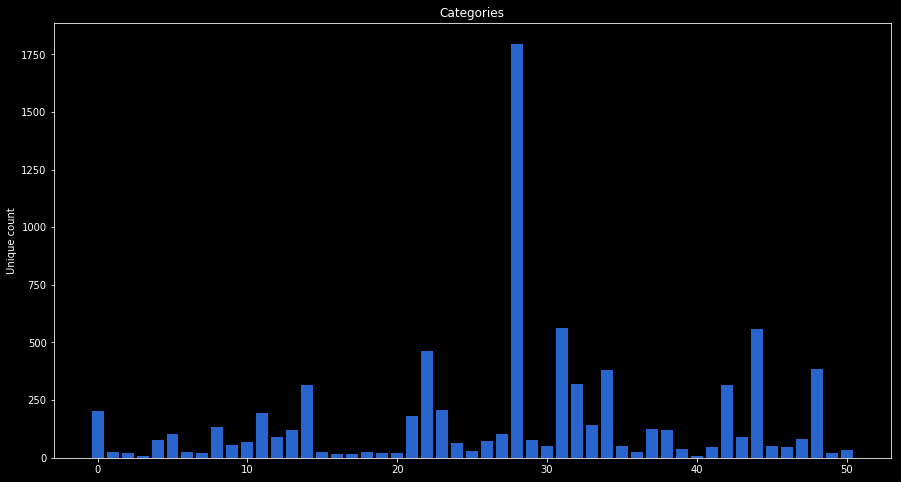

In [10]:
yPosition = np.arange(NUMBER_CATEGORIES)

plt.figure(figsize=(15,8))
plt.bar(yPosition, countCategories, color=colors[0])

plt.ylabel('Unique count')
plt.title('Categories')
axes = plt.gca()
#axes.set_ylim([0,50])
plt.show()

In [11]:
selectedCategories = list(filter(lambda x:  50 < x[1] <= 100, indexedCountCategories))
selectedCategories

[(4, 76),
 (9, 54),
 (10, 68),
 (12, 89),
 (24, 64),
 (26, 72),
 (29, 77),
 (30, 52),
 (43, 91),
 (47, 82)]

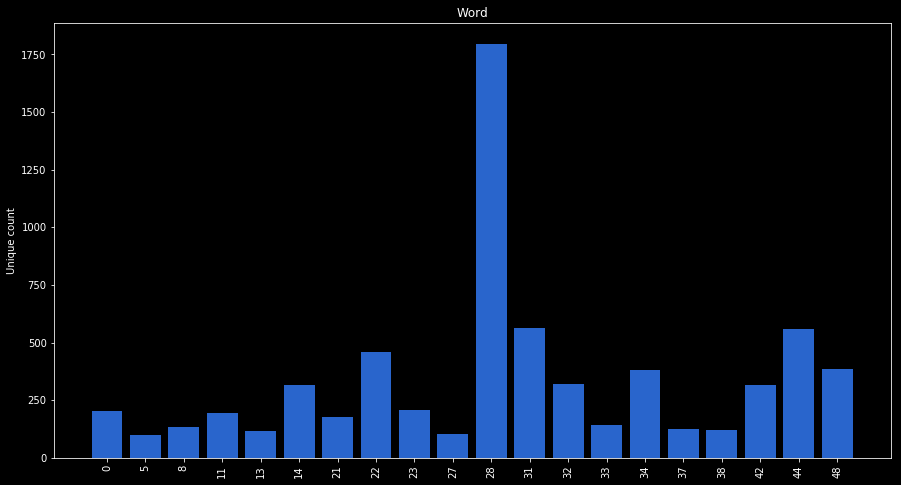

Number of categories with morethan 100 points: 20
Mean of number of points in categories with more than 100 points: 337.0


In [12]:
selectedCategories = list(filter(lambda x: x[1] > 100, indexedCountCategories))

labels = [category[0] for category in selectedCategories]
values = [category[1] for category in selectedCategories]
yPosition = np.arange(len(selectedCategories))

plt.figure(figsize=(15,8))
plt.bar(yPosition, values, color=colors[0])
plt.xticks(yPosition, labels, rotation=90)
plt.ylabel('Unique count')
plt.title('Word')
 
plt.show()

print('Number of categories with more'
      'than 100 points: {}'.format(str(len(selectedCategories))))
print('Mean of number of points in categories with more than 100 points: {}'.format(np.mean([cat[1] for cat in selectedCategories])))

# Distribution du vocabulaire par catégorie

countVector.shape: (104, 822)
wordCount.shape: (1, 822)
[['de', 0.046953046953046952], ['je', 0.033300033300033303], ['et', 0.02763902763902764], ['ai', 0.022311022311022312], ['que', 0.02197802197802198]]


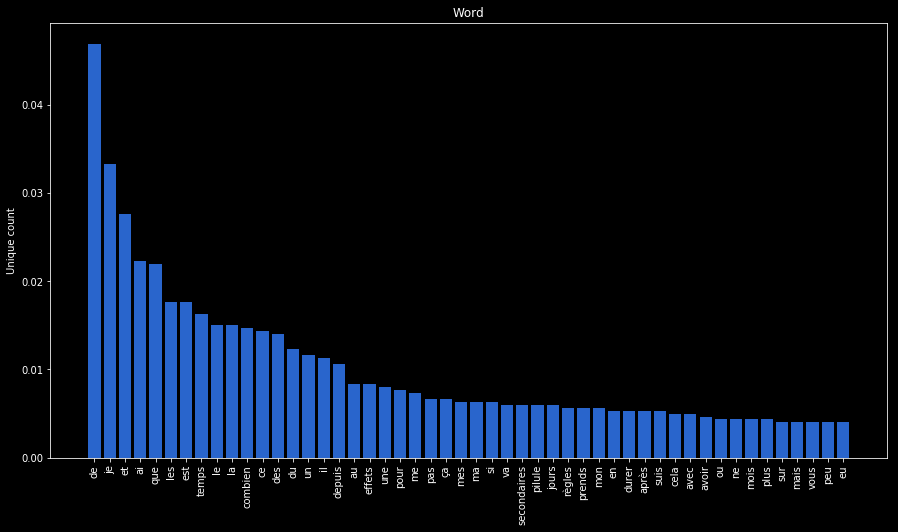

In [13]:
category = 27
selectedSentences = x[y == category][1:]
sortedVocabularyCategory =\
    vectorizeVocabulary(list(map(lambda x: str(x), selectedSentences)),
                        verbose=True, density=True)
plotVocabulary(sortedVocabularyCategory)

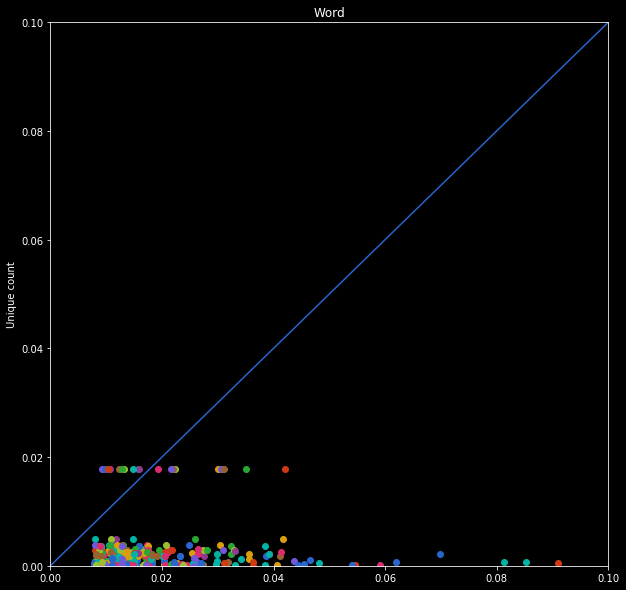

In [14]:
vocabularyDict = dict(sortedVocabulary)
plt.figure(figsize=(10,10))
m = 0
selectedWords = {}

for category in range(NUMBER_CATEGORIES):
    selectedSentences = x[y == category][1:]
    sortedVocabularyCategory = vectorizeVocabulary(list(map(lambda x: str(x),
                                                            selectedSentences)),
                                                   density=True)

    for word in sortedVocabularyCategory[:20]:
        if not word[0] in STOP_WORDS:
            m = max(word[1], m)
            plt.scatter(word[1], vocabularyDict[word[0]],
                        color=colors[category % len(colors)], label=str(category))
            if category in selectedWords:
                selectedWords[category].append([*word, vocabularyDict[word[0]]])
            else:
                selectedWords[category] = [[*word, vocabularyDict[word[0]]]]

plt.plot([0, 1], color=colors[0])
plt.ylim(0, 1.1 * m)
plt.xlim(0, 1.1 * m)
plt.ylabel('Unique count')
plt.title('Word')
plt.show()

In [1]:
selectedWords[:10]

NameError: name 'selectedWords' is not defined

# Explore the medicaments names 

In [16]:
MEDICAMENTS = []
medicsPath = os.path.join(dataFolder, 'medicaments_france.xls')
medic_db = pd.read_excel(medicsPath)

for m in medic_db['Dénomination spécialité']:
    med = []
    for w in m.split():
        if w.lower()!=w:
            med.append(w)
    med = ' '.join(med)
    if len(med)!=0:
        med = med.lower()
        if med not in MEDICAMENTS:
            MEDICAMENTS.append(med.lower())

for m in medic_db['Libellé ATC']:
    med = m.split()[0].lower()
    if med not in MEDICAMENTS:
        MEDICAMENTS.append(med)

# add the first names of the medicaments 
added = []
for med in MEDICAMENTS:
    med_first = med.split()[0]
    if med_first not in MEDICAMENTS:
        MEDICAMENTS.append(med_first)
        added.append(med_first)

# removing some undesired elements which are not medicaments
MEDICAMENTS.remove('a')
MEDICAMENTS.remove('b')
MEDICAMENTS.remove('x')
MEDICAMENTS.remove('l')
MEDICAMENTS.remove('un')
print('Liste de médicaments regroupant les libéllés ATC et les'
      'dénominations de spécialité, de taille: {}'.format(len(MEDICAMENTS)))
print('Sample of medicament names: ', MEDICAMENTS[:10])

Liste de médicaments regroupant les libéllés ATC et lesdénominations de spécialité, de taille: 9255
Sample of medicament names:  ['ubistesin adrenalinee', 'forene,', 'sevorane,', 'chirocaïne', 'duodopa', 'synagis', 'kaletra', 'humira', 'norvir', 'viekirax']


In [17]:
medicaments_occurences = []
nb_occurences = 0
unique_occurences = []
for xx in tqdm(x):
    occur = []
    for w in xx[1].split():
        w = w.lower()
        if w in MEDICAMENTS:
            occur.append(w)
            nb_occurences +=1
            if w not in unique_occurences:
                unique_occurences.append(w)
    medicaments_occurences.append(occur)
print('{} medicaments occurences in the dataset'.format(nb_occurences))
print('{} unique medicament names occuring in the dataset'.format(len(unique_occurences)))

100%|██████████| 8028/8028 [00:14<00:00, 542.27it/s]

5572 medicaments occurences in the dataset
837 unique medicament names occuring in the dataset


In [18]:
def selectCat(x, y, cat_index, medicaments_occurences = medicaments_occurences):
    cat_ix = []
    for xx, yy in zip(x, y):
        if yy[1] == cat_index:
            cat_ix.append(xx[0])
    cat_ix = np.array(cat_ix)
    selected_questions = x[cat_ix]
    selected_medics = [medicaments_occurences[ix] for ix in cat_ix]
    return selected_questions, selected_medics

In [23]:
cat_index = 22
cat_questions, med_questions = selectCat(x, y, 22)
cat_questions[:10]

array([[8, "L'atenolol, c'est quoi ?"],
       [42, 'risperdal ?? (neuroleptique)'],
       [49, 'urbanyl?'],
       [92, "qu'est-ce que le primperan ?"],
       [128, 'deroxat ??'],
       [136, 'qui connait le rhophylac?'],
       [143, 'euphytose : médicament ou placebo?'],
       [146, 'PAS DE QUESTION SUR UN MEDICAMENT'],
       [161, "qu'est ce que la surgestone?"],
       [165, 'qui connait le guronsan?']], dtype=object)

In [25]:
# try to see if there is a correletation between medicament names and the categories
meds_by_category = {}
for cat in set(y[:,1]):
    meds_by_category[cat] = []
    
for yy, meds in zip(y, medicaments_occurences):
    for med in meds:
        if med not in meds_by_category[yy[1]]:
            meds_by_category[yy[1]].append(med)

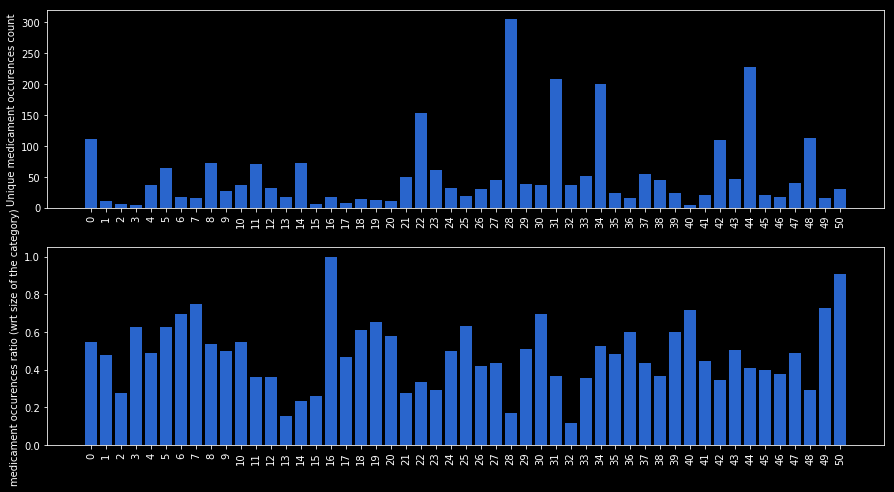

In [65]:
labels = [nb_cat for nb_cat in np.arange(NUMBER_CATEGORIES)]
values = [len(meds_cat) for meds_cat in list(meds_by_category.values())]
ratio_values = [v/l for (v, l) in zip(values, countCategories)]
yPosition = np.arange(NUMBER_CATEGORIES)

plt.figure(figsize=(15,8))
plt.title('Divesity of medicament names in the different categories')
plt.subplot(211)
plt.bar(yPosition, values, color=colors[0])
plt.xticks(yPosition, labels, rotation=90)
plt.ylabel('Unique medicament occurences count')

plt.subplot(212)
plt.bar(yPosition, ratio_values, color=colors[0])
plt.xticks(yPosition, labels, rotation=90)
plt.ylabel('medicament occurences ratio (wrt size of the category)')

plt.show()

# Explore the variety of questions

In [69]:
cat_index = 46
cat_questions, med_questions = selectCat(x, y, cat_index)
cat_questions[:10]

array([[56,
        'le prix du générique lisinopril 20mg est passé subitement de 12,39€ à 13,25€ , est ce normal?'],
       [75, 'je souhaiterais savoir quel est le prix du vermifuge humain ?'],
       [457,
        'je voudrais commencer une cure de cystine b6. j ai entendu dire qu en france le prix etait de 3 € ?'],
       [484,
        "j'ai arrêté cycléane 20 il y a 4 ans et là j'attends mes règles pour pouvoir la reprendre. je voudrais savoir combien coûtent les 3 plaquettes maintenant ?"],
       [703,
        'obligé de payer mon rivotril 50 euros la bouteille , normal ?'],
       [1003, 'cérazette ? Combien ça coûte ?'],
       [1047,
        'obligé de payer mon rivotril 50 euros la bouteille , normal ?'],
       [1091, 'tarif trinordiol?'],
       [1602, 'Quel est le prix du générique biogaran de mercilon ?'],
       [1718, 'prix cycléane 20 ?']], dtype=object)

In [67]:
# see short questions
min_length = 15
short_questions = []
for xx in x:
    if len(xx[1]) <= min_length:
        short_questions.append((xx[1], y[xx[0],1]))

In [68]:
short_questions

[('urbanyl?', 22),
 ('deroxat ??', 22),
 ('C quoi neisvac?', 22),
 ('REJET', 14),
 ('neoral', 22),
 ('norset', 22),
 ('optilova 20 ?', 22),
 ('la damiana?', 22),
 ('méningitec ?', 22),
 ('exacyl ??', 22),
 ('veratran', 22),
 ('lycopodium ?', 22),
 ('prozac CRAT', 44),
 ('valdoxan ??', 22),
 ('floxyfral .?', 22),
 ('belara ??', 22),
 ('vicks vaporub?', 22),
 ('deroxat ?', 22),
 ('prothiaden ?', 22),
 ('le lyrica ?', 22),
 ('surgestone??', 22),
 ('revaxis?', 22),
 ('di-hydan ??', 22),
 ('hémoclar ?', 31),
 ('gardasile ?', 22),
 ('norset ? Coût ?', 46),
 ('xanax + alcool?', 33),
 ('lorazepam?', 22),
 ('fiche prozac', 22),
 ('c koi moneva?', 22),
 ('RCP imurel?', 22),
 ('onfos naemis', 22),
 ('le leprozol', 22),
 ('xanax', 22),
 ('quezaco emla ?', 22),
 ('abilify ?', 22),
 ('lutéran?', 22),
 ('IEC et toux', 28),
 ('cycléane 20?', 22),
 ('levothyrox ANSM', 22),
 ('lutenyl?', 22),
 ('monazol?', 22),
 ('pantestone ??', 22),
 ('norprolac', 22),
 ('ixel ?', 22),
 ('contalax ??', 22),
 ('diane e